# 13__motif_chip_tf_ts_redo
# testing whether gene tissue-sp correlates with chip/motif tissue-sp

after talking to lucas: find tissue-sp for each TF, find all genes that have that motif/chip peak, calc. average tissue-sp. of those genes, correlate that with the tissue-sp. (and subset by class, if needed)

chip and fimo files are from PJ

took fimo mappings from marta's directory

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def get_tss_id(row):
    if "Enhancer" in row.tss_name:
        return row.tss_name.split("__")[1]
    else:
        return row.tss_name.split("__")[2]

## variables

### for all promoters (3kb)

In [4]:
chip_f = "chip_all.txt"

In [5]:
fimo_f = "fimo_all_biotypes.txt"

In [6]:
tss_ts_f = "hg19.cage_peak_phase1and2combined_counts.osc.tissue_specificity.txt"
enh_ts_f = "human_permissive_enhancers_phase_1_and_2_expression_count_matrix.tissue_specificity.txt"

In [7]:
tss_ts_f = "hg19.cage_peak_phase1and2combined_counts.osc.tissue_specificity.txt"
enh_ts_f = "human_permissive_enhancers_phase_1_and_2_expression_count_matrix.tissue_specificity.txt"

In [8]:
annot_f = "../../misc/00__tss_properties/TSS_FantomCat_all.TSSperENSG.txt"
fimo_map_f = "../../misc/04__jaspar_id_map/2018_03_09_gencode_jaspar_curated.txt"
chip_map_f = "ensembl_92_gene_id_to_name.txt"

In [9]:
tf_ts_f = "gtex_tissue_specificity_tau.txt"

### for all promoters (114bp)

In [10]:
chip_114_f = "chip_all_114.txt"

In [11]:
fimo_114_f = "../../misc/05__fimo/TFmotifs__intersect_114bpTSS.uniq.txt"

### pool1 tss

In [12]:
pool1_annot_f = "../../misc/00__tss_properties/TABLE_ALL_TSS_and_flipped.properties.PromType.txt"

## 1. import data

In [13]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo = fimo[fimo["shuffled"] != "shuffled"]
fimo.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype
2533673,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding
2533674,RUNX1,NaN,"chr2:66610364..66610365,+",NaN,13,23,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,intergenic
2533675,RUNX1,NaN,"chr6:29424953..29424961,+",NaN,47,57,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,protein_coding
2533676,RUNX1,p1@ENST00000412759,"chr1:120838328..120838358,-",NaN,169,179,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,div_lnc
2533677,RUNX1,p1@TXNDC11,"chr16:11836595..11836726,-",NaN,235,245,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,div_pc


In [14]:
chip = pd.read_table(chip_f, sep="\t")
chip.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,10003525,24.543343,div_pc,10003524.5,-139.5,ARID3A
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,10003414,42.461327,div_pc,10003413.5,-28.5,ATF2
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,10003498,69.683125,div_pc,10003497.5,-112.5,ATF2
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,10003458,27.073183,div_pc,10003457.5,-72.5,ATF3
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,10003425,55.235219,div_pc,10003424.5,-39.5,BCL3


In [15]:
annot = pd.read_table(annot_f, sep="\t")
promtype2 = annot[["gene_id", "PromType2"]].drop_duplicates()
promtype2.head()

,gene_id,PromType2
0,ENSG00000000003.10,protein_coding
8,ENSG00000000005.5,protein_coding
13,ENSG00000000419.8,protein_coding
17,ENSG00000000457.9,protein_coding
24,ENSG00000000460.12,protein_coding


In [16]:
fimo_map = pd.read_table(fimo_map_f, sep="\t")
fimo_map.head()

,motif_id,motif_name,Gene ID,comment
0,MA0002.2,RUNX1,ENSG00000159216,NaN
1,MA0003.3,TFAP2A,ENSG00000137203,NaN
2,MA0007.3,Ar,ENSG00000169083,Mus musculus; human ortholog selected
3,MA0009.2,T,ENSG00000164458,NaN
4,MA0014.2,PAX5,ENSG00000196092,NaN


In [17]:
chip_map = pd.read_table(chip_map_f, sep="\t")
chip_map.head()

,Gene stable ID,Gene name
0,ENSG00000276626,RF00100
1,ENSG00000201317,RNU4-59P
2,ENSG00000200823,SNORD114-2
3,ENSG00000221598,MIR1249
4,ENSG00000199595,RF00019


In [18]:
tf_ts = pd.read_table(tf_ts_f, sep="\t")
tf_ts.head()

,GeneID,tissue_spec,tissue_spec_tau
0,ENSG00000223972.4,0.589677,0.986427
1,ENSG00000227232.4,0.203154,0.225353
2,ENSG00000243485.2,NaN,NaN
3,ENSG00000237613.2,NaN,NaN
4,ENSG00000268020.2,NaN,NaN


In [19]:
tss_ts = pd.read_table(tss_ts_f, sep="\t")
tss_ts.head()

,tss_id,tissue_spec
0,01STAT:MAPPED,0.087543
1,"chr10:100013403..100013414,-",0.980206
2,"chr10:100027943..100027958,-",0.782627
3,"chr10:100076685..100076699,+",0.978467
4,"chr10:100150910..100150935,-",0.970738


In [20]:
enh_ts = pd.read_table(enh_ts_f, sep="\t")
enh_ts.head()

,tss_id,tissue_spec
0,chr1:839741-840250,0.974827
1,chr1:840753-841210,0.967327
2,chr1:845485-845678,0.966489
3,chr1:855764-856157,0.982428
4,chr1:856539-856757,0.976588


In [21]:
all_ts = tss_ts.append(enh_ts)

In [22]:
chip_114 = pd.read_table(chip_114_f, sep="\t", header=None)
chip_114.columns = ["tss_chr", "tss_start", "tss_end", "tss_name", "tss_score", "tss_strand", "motif_chr",
                    "motif_start", "motif_end", "motif_score", "motif_id", "cell", "overlap"]
chip_114["tss_id"] = chip_114.apply(get_tss_id, axis=1)
chip_114.sample(5)

,tss_chr,tss_start,tss_end,tss_name,tss_score,tss_strand,motif_chr,motif_start,motif_end,motif_score,motif_id,cell,overlap,tss_id
728671,chr7,64467030,64467145,protein_coding__p1@ZNF117__chr7:64467057..6446...,0,-,chr7,64467113,64467114,59.396676,GABPA,K562,1,"chr7:64467057..64467078,-"
229267,chr14,23235730,23235845,"div_lnc__p1@ENST00000553792,p1@ENST00000554194...",0,-,chr14,23235795,23235796,15.186139,PPARGC1A,HepG2,1,"chr14:23235744..23235781,-"
538274,chr22,43010903,43011018,"div_pc__p2@POLDIP3__chr22:43010928..43010947,-",0,-,chr22,43010987,43010988,493.035528,GABPA,A549,1,"chr22:43010928..43010947,-"
221889,chr13,51796426,51796541,protein_coding__p1@FAM124A__chr13:51796497..51...,0,+,chr13,51796482,51796483,41.651739,CTCF,GM12875,1,"chr13:51796497..51796517,+"
599001,chr4,2243813,2243928,"protein_coding__p1@HAUS3,p1@POLN__chr4:2243839...",0,-,chr4,2243822,2243823,33.583589,E2F6,K562,1,"chr4:2243839..2243865,-"


In [23]:
fimo_114 = pd.read_table(fimo_114_f, sep="\t", header=None)
fimo_114.columns = ["tss_chr", "tss_start", "tss_end", "tss_name", "tss_score", "tss_strand", "motif_chr",
                    "motif_start", "motif_end", "motif_id", "motif_score", "motif_strand"]
fimo_114["tss_id"] = fimo_114.apply(get_tss_id, axis=1)
fimo_114.head()

,tss_chr,tss_start,tss_end,tss_name,tss_score,tss_strand,motif_chr,motif_start,motif_end,motif_id,motif_score,motif_strand,tss_id
0,chr1,10003350,10003351,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003338,10003351,NFKB1,7.63265,-,"chr1:10003372..10003465,-"
1,chr1,10003350,10003351,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003338,10003351,NFKB2,13.00000,+,"chr1:10003372..10003465,-"
2,chr1,10003350,10003351,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003338,10003351,NFKB2,7.42424,-,"chr1:10003372..10003465,-"
3,chr1,10003350,10003352,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003339,10003352,NFKB1,3.24490,-,"chr1:10003372..10003465,-"
4,chr1,10003350,10003352,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003339,10003352,NFKB1,3.38776,+,"chr1:10003372..10003465,-"


In [24]:
pool1_annot = pd.read_table(pool1_annot_f, sep="\t")
pool1_annot.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


In [28]:
pool1_annot.sample(5)

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
2896,NaN,NaN,"chr22:41047771..41047885,+","chr22:41047850..41047851,+",enhancer,NaN,0.945421,NaN,enhancer,Enhancer,...,NaN,NaN,NaN,NaN,NaN,0,0,Enhancer,Enhancer,Enhancer
1069,ENSG00000218510.3,ENST00000420503,"chr1:22351918..22352032,-","chr1:22351977..22352017,+",p1@LINC00339,0bp_to_ENST00000420503_5end,12.530098,LINC00339,lincRNA,Lincrna,...,NaN,NaN,NaN,NaN,NaN,0,0,intergenic,intergenic,intergenic
2707,NaN,NaN,"chr9:140134888..140135002,+","chr9:140134967..140134968,+",enhancer,NaN,0.802970,NaN,enhancer,Enhancer,...,NaN,NaN,NaN,NaN,NaN,0,0,Enhancer,Enhancer,Enhancer
2844,NaN,NaN,"chr17:76375037..76375152,+","chr17:76375037..76375152,+",eQTL_Ulirsch_rs4490057_A_+_A/G,NaN,NaN,NaN,NaN,control,...,NaN,NaN,NaN,NaN,NaN,1,1,control,control,control
2396,NaN,NaN,"chr11:68922919..68923033,+","chr11:68922998..68922999,+",enhancer,NaN,0.101254,NaN,enhancer,Enhancer,...,NaN,NaN,NaN,NaN,NaN,0,0,Enhancer,Enhancer,Enhancer


## 2. grab gene_ids for motif_names in chip/fimo 

In [23]:
fimo_tfs = list(fimo["motif_id"].unique())
len(fimo_tfs)

435

In [24]:
chip_tfs = list(chip["motif_id"].unique())
len(chip_tfs)

160

In [25]:
manual_aliases = {"SIN3AK20": "SIN3A", "KAP1": "TRIM28", "SREBP1": "SREBF1", "ZZZ3": "AC118549.1", 
                  "RPC155": "POLR3A", "RDBP": "NELFE", "FAM48A": "SUPT20H", "MZF1(VAR.2)": "MZF1",
                  "RORA(VAR.2)": "RORA", "JUN(VAR.2)": "JUN", "JUND(VAR.2)": "JUND", "NKX2-5(VAR.2)": "NKX2-5",
                  "JDP2(VAR.2)": "JDP2", "NR2F6(VAR.2)": "NR2F6", "RARA(VAR.2)": "RARA", "TFAP2A(VAR.2)": "TFAP2A",
                  "TFAP2B(VAR.2)": "TFAP2B", "TFAP2B(VAR.3)": "TFAP2B", "TFAP2C(VAR.2)": "TFAP2C", 
                  "SREBF2(VAR.2)": "SREBF2", "SREBF1(VAR.2)": "SREBF1", "RARB(VAR.2)": "RARB", 
                  "RARG(VAR.2)": "RARG", "TFAP2A(VAR.3)": "TFAP2A", "TFAP2C(VAR.3)": "TFAP2C", "MIX-A": "MIXL1"}
manual_gene_ids = {"HSF1": "ENSG00000185122", "HNF1B": "ENSG00000275410", "KLF13": "ENSG00000169926",
                   "POU5F1": "ENSG00000204531", "SMARCB1": "ENSG00000099956", "RXRB": "ENSG00000204231"}

In [26]:
def get_gene_id(motif_names, fimo_map, chip_map, manual_aliases, manual_gene_ids):
    gene_id_map = {}
    for motif in motif_names:
        motif = motif.upper()
        
        if "::" in motif:
            # fusion protein, continue
            gene_id_map[motif] = np.nan
            continue
        
        if motif in manual_gene_ids:
            gene_id_map[motif] = manual_gene_ids[motif]
            continue
            
        try:
            fimo_id = fimo_map[fimo_map["motif_name"] == motif]["Gene ID"].iloc[0]
        except:
            fimo_id = "none"
        try:
            chip_id = chip_map[chip_map["Gene name"] == motif]["Gene stable ID"].iloc[0]
        except:
            chip_id = "none"
        if fimo_id == "none" and chip_id == "none":
            try:
                alias = manual_aliases[motif]
            except:
                print("%s: no id, no alias" % motif)
                gene_id_map[motif] = np.nan
                continue
            try:
                real_id = chip_map[chip_map["Gene name"] == alias]["Gene stable ID"].iloc[0]
            except:
                print("%s: no id found for alias %s" % (motif, alias))
                gene_id_map[motif] = np.nan
        elif fimo_id != "none" and chip_id == "none":
            #print("found fimo id")
            gene_id_map[motif] = fimo_id
        elif fimo_id == "none" and chip_id != "none":
            #print("found chip id")
            gene_id_map[motif] = chip_id
        elif fimo_id != "none" and chip_id != "none":
            if fimo_id == chip_id:
                #print("found fimo/chip id that agrees")
                gene_id_map[motif] = fimo_id
            else:
                #print("%s: found fimo/chip id that disagree: %s, %s\n" % (motif, fimo_id, chip_id))
                real_id = manual_gene_ids[motif]
                gene_id_map[motif] = real_id
    return gene_id_map

In [27]:
chip_id_map = get_gene_id(chip_tfs, fimo_map, chip_map, manual_aliases, manual_gene_ids)

GRP20: no id, no alias


In [28]:
fimo_id_map = get_gene_id(fimo_tfs, fimo_map, chip_map, manual_aliases, manual_gene_ids)

RHOX11: no id, no alias


In [29]:
chip_id_map = pd.DataFrame.from_dict(chip_id_map, orient="index").reset_index()
chip_id_map.columns = ["motif_name", "gene_id"]
chip_id_map.head()

,motif_name,gene_id
0,ARID3A,ENSG00000116017
1,ATF2,ENSG00000115966
2,ATF3,ENSG00000162772
3,BCL3,ENSG00000069399
4,BCLAF1,ENSG00000029363


In [30]:
fimo_id_map = pd.DataFrame.from_dict(fimo_id_map, orient="index").reset_index()
fimo_id_map.columns = ["motif_name", "gene_id"]
fimo_id_map.head()

,motif_name,gene_id
0,RUNX1,ENSG00000159216
1,TFAP2A,ENSG00000137203
2,AR,ENSG00000169083
3,T,ENSG00000164458
4,PAX5,ENSG00000196092


## 3. merge fimo/chip with tss tissue-sp values
why are some TSSs missing?

In [31]:
len(fimo)

4455254

In [32]:
fimo_ts = fimo.merge(all_ts, on="tss_id")
print(len(fimo_ts))
fimo_ts.sample(5)

4022690


,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec
3626634,SP2,NaN,chr4:75183618-75183847,NaN,2693,2707,+,16.34480,1.650000e-06,0.0359,cccccgcctccctgg,SP2,enhancer,0.984432
3286437,SP2,NaN,chr10:3107913-3108181,NaN,2627,2641,+,17.74140,4.560000e-07,0.0228,CTCCCGCCTCCCCGC,SP2,enhancer,0.993805
4506,KLF16,p1@TTLL12,"chr22:43583079..43583153,-",NaN,1765,1775,-,14.24140,8.730000e-06,0.0453,CCCCCGCCCCT,KLF16,protein_coding,0.369563
2757756,Rarb,NaN,chr8:138946519-138946780,NaN,1540,1555,+,5.62069,6.010000e-06,0.2040,TCATTTCAAAAGGTCA,Rarb,enhancer,0.988706
2487956,SP1,NaN,chr11:78113040-78113383,NaN,1722,1732,+,15.25000,4.250000e-06,0.0482,TCCCCTCCCCT,SP1,enhancer,0.972223


In [33]:
missing_tss_ids_fimo = fimo[~fimo["tss_id"].isin(all_ts["tss_id"])]["tss_id"].unique()
len(missing_tss_ids_fimo)

7619

In [34]:
len(chip)

5940131

In [35]:
chip_ts = chip.merge(all_ts, on="tss_id")
print(len(chip_ts))
chip_ts.sample(5)

5293069


,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id,tissue_spec
3388423,chr12,70949654,70952654,NaN,chr12:70951536-70951916,0,+,FOS,chr12,70950409,70950410,37.473064,enhancer,70950409.5,-1244.5,FOS,0.953124
4776612,chr6,12232766,12235766,NaN,chr6:12234649-12234812,0,+,BATF,chr6,12232812,12232813,49.475413,enhancer,12232812.5,-1953.5,BATF,0.989084
1058094,chr16,87415538,87418538,"p@chr16:87417524..87417546,+","chr16:87417524..87417546,+",0,+,TCF7L2,chr16,87417760,87417761,25.858647,protein_coding,87417760.5,222.5,TCF7L2,0.877600
3068508,chr10,125852206,125855206,NaN,chr10:125853998-125854207,0,+,NR3C1,chr10,125853210,125853211,22.243029,enhancer,125853210.5,-995.5,NR3C1,0.977893
4343870,chr21,38934257,38937257,NaN,chr21:38935728-38936411,0,+,FOS,chr21,38936817,38936818,192.846589,enhancer,38936817.5,560.5,FOS,0.777158


In [36]:
missing_tss_ids_chip = chip[~chip["tss_id"].isin(all_ts["tss_id"])]["tss_id"].unique()
len(missing_tss_ids_chip)

6469

In [37]:
fimo_114_ts = fimo_114.merge(all_ts, on="tss_id")
print(len(fimo_114_ts))
fimo_114_ts.sample(5)

1088148


,tss_chr,tss_start,tss_end,tss_name,tss_score,tss_strand,motif_chr,motif_start,motif_end,motif_id,motif_score,motif_strand,tss_id,tissue_spec
360517,chr4,48988228,48988239,protein_coding__p1@CWH43__chr4:48988285..48988...,0,+,chr4,48988228,48988239,Klf1,17.15150,-,"chr4:48988285..48988298,+",0.931610
463883,chr9,136223347,136223357,protein_coding__p1@SURF1__chr9:136223324..1362...,0,-,chr9,136223347,136223357,ETV1,11.43640,-,"chr9:136223324..136223371,-",0.317153
517750,chr1,212658424,212658429,Enhancer__chr1:212658172-212658571,0,+,chr1,212658424,212658435,JUND,13.21280,+,chr1:212658172-212658571,0.985693
398473,chr6,24126434,24126446,protein_coding__p1@NRSN1__chr6:24126427..24126...,0,+,chr6,24126434,24126446,TGIF2,9.44954,-,"chr6:24126427..24126497,+",0.897363
884429,chr3,59316168,59316183,Enhancer__chr3:59316034-59316229,0,+,chr3,59316168,59316183,STAT1::STAT2,9.07576,-,chr3:59316034-59316229,0.990614


In [38]:
chip_114_ts = chip_114.merge(all_ts, on="tss_id")
print(len(chip_114_ts))
chip_114_ts.sample(5)

947044


,tss_chr,tss_start,tss_end,tss_name,tss_score,tss_strand,motif_chr,motif_start,motif_end,motif_score,motif_id,cell,overlap,tss_id,tissue_spec
845622,chr20,52277624,52277739,Enhancer__chr20:52277634-52277772,0,+,chr20,52277637,52277638,23.654593,CTCF,H1-hESC,1,chr20:52277634-52277772,0.980052
628435,chr7,55955068,55955183,"protein_coding__p1@ZNF713,p2@MRPS17__chr7:5595...",0,+,chr7,55955174,55955175,43.545086,POLR2A,K562,1,"chr7:55955139..55955190,+",0.634946
697355,chrX,134478640,134478755,protein_coding__p1@ZNF449__chrX:134478706..134...,0,+,chrX,134478642,134478643,95.098472,CREB1,A549,1,"chrX:134478706..134478736,+",0.534745
253249,chr16,30569788,30569903,protein_coding__p4@ZNF764__chr16:30569801..305...,0,-,chr16,30569826,30569827,73.077057,TAF1,K562,1,"chr16:30569801..30569845,-",0.778547
269413,chr16,74700722,74700837,protein_coding__p1@RFWD3__chr16:74700747..7470...,0,-,chr16,74700774,74700775,80.670008,EGR1,K562,1,"chr16:74700747..74700804,-",0.430225


## 4. find tissue-sp per TF
#### use gtex for now

In [39]:
tf_ts["gene_id"] = tf_ts["GeneID"].str.split(".", expand=True)[0]
tf_ts.head()

,GeneID,tissue_spec,tissue_spec_tau,gene_id
0,ENSG00000223972.4,0.589677,0.986427,ENSG00000223972
1,ENSG00000227232.4,0.203154,0.225353,ENSG00000227232
2,ENSG00000243485.2,NaN,NaN,ENSG00000243485
3,ENSG00000237613.2,NaN,NaN,ENSG00000237613
4,ENSG00000268020.2,NaN,NaN,ENSG00000268020


In [40]:
chip_id_map_ts = chip_id_map.merge(tf_ts, on="gene_id", how="left")
chip_id_map_ts.sample(5)

,motif_name,gene_id,GeneID,tissue_spec,tissue_spec_tau
152,POLR3G,ENSG00000113356,ENSG00000113356.6,0.233538,0.652665
108,GATA3,ENSG00000107485,ENSG00000107485.11,0.283021,0.841030
85,TAL1,ENSG00000162367,ENSG00000162367.7,0.229525,0.622278
135,ZNF217,ENSG00000171940,ENSG00000171940.9,0.218369,0.509385
148,BDP1,ENSG00000145734,ENSG00000145734.14,0.206479,0.308354


In [41]:
chip_id_map_ts[pd.isnull(chip_id_map_ts["tissue_spec"])]

,motif_name,gene_id,GeneID,tissue_spec,tissue_spec_tau
127,GRP20,NaN,NaN,NaN,NaN


In [42]:
fimo_id_map_ts = fimo_id_map.merge(tf_ts, on="gene_id", how="left")
fimo_id_map_ts.sample(5)

,motif_name,gene_id,GeneID,tissue_spec,tissue_spec_tau
104,E2F3,ENSG00000112242,ENSG00000112242.10,0.210964,0.398423
146,SP2,ENSG00000167182,ENSG00000167182.11,0.200948,0.160222
247,ZIC1,ENSG00000152977,ENSG00000152977.5,0.333715,0.908867
128,MAFK,ENSG00000198517,ENSG00000198517.5,0.207347,0.327533
261,RARA,ENSG00000131759,ENSG00000131759.13,0.211353,0.405284


In [43]:
fimo_id_map_ts[pd.isnull(fimo_id_map_ts["tissue_spec"])]

,motif_name,gene_id,GeneID,tissue_spec,tissue_spec_tau
6,DDIT3::CEBPA,NaN,NaN,NaN,NaN
27,MAX::MYC,NaN,NaN,NaN,NaN
30,PPARG::RXRA,NaN,NaN,NaN,NaN
36,RXRA::VDR,NaN,NaN,NaN,NaN
46,TAL1::TCF3,NaN,NaN,NaN,NaN
47,HAND1::TCF3,NaN,NaN,NaN,NaN
65,NR1H2::RXRA,NaN,NaN,NaN,NaN
68,NFIC::TLX1,NaN,NaN,NaN,NaN
77,GATA1::TAL1,NaN,NaN,NaN,NaN
79,POU5F1::SOX2,NaN,NaN,NaN,NaN


## 5. merge fimo/chip with tf spec values

In [44]:
chip_ts["motif_upper"] = chip_ts["motif_id"].str.upper()
chip_114_ts["motif_upper"] = chip_114_ts["motif_id"].str.upper()
chip_ts.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id,tissue_spec,motif_upper
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,10003525,24.543343,div_pc,10003524.5,-139.5,ARID3A,0.3734,ARID3A
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,10003414,42.461327,div_pc,10003413.5,-28.5,ATF2,0.3734,ATF2
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,10003498,69.683125,div_pc,10003497.5,-112.5,ATF2,0.3734,ATF2
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,10003458,27.073183,div_pc,10003457.5,-72.5,ATF3,0.3734,ATF3
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,10003425,55.235219,div_pc,10003424.5,-39.5,BCL3,0.3734,BCL3


In [45]:
chip_ts = chip_ts.merge(chip_id_map_ts, left_on="motif_upper", right_on="motif_name", how="left")
chip_114_ts = chip_114_ts.merge(chip_id_map_ts, left_on="motif_upper", right_on="motif_name", how="left")
chip_ts.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,...,pos,pos_rel,motif_id,tissue_spec_x,motif_upper,motif_name,gene_id,GeneID,tissue_spec_y,tissue_spec_tau
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,...,10003524.5,-139.5,ARID3A,0.3734,ARID3A,ARID3A,ENSG00000116017,ENSG00000116017.6,0.243316,0.711899
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,...,10003413.5,-28.5,ATF2,0.3734,ATF2,ATF2,ENSG00000115966,ENSG00000115966.12,0.204556,0.262339
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,...,10003497.5,-112.5,ATF2,0.3734,ATF2,ATF2,ENSG00000115966,ENSG00000115966.12,0.204556,0.262339
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,...,10003457.5,-72.5,ATF3,0.3734,ATF3,ATF3,ENSG00000162772,ENSG00000162772.12,0.216412,0.483653
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,...,10003424.5,-39.5,BCL3,0.3734,BCL3,BCL3,ENSG00000069399,ENSG00000069399.8,0.211082,0.400526


In [46]:
fimo_ts["motif_upper"] = fimo_ts["motif_id"].str.upper()
fimo_114_ts["motif_upper"] = fimo_114_ts["motif_id"].str.upper()
fimo_ts.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec,motif_upper
0,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding,0.349684,RUNX1
1,TFAP2A,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1604,1614,+,13.8909,9.460000e-06,0.155,CCCCTCAGGCT,TFAP2A,protein_coding,0.349684,TFAP2A
2,PAX5,p1@SYVN1,"chr11:64901978..64902009,-",NaN,638,656,+,14.5484,5.460000e-06,0.107,ctgggcgacagagcaagac,PAX5,protein_coding,0.349684,PAX5
3,E2F1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,616,627,+,14.1475,8.620000e-06,1.000,gatggcgccaat,E2F1,protein_coding,0.349684,E2F1
4,ELK1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1947,1956,+,16.2128,3.920000e-06,0.605,gccggAAGTG,ELK1,protein_coding,0.349684,ELK1


In [47]:
fimo_ts = fimo_ts.merge(fimo_id_map_ts, left_on="motif_upper", right_on="motif_name", how="left")
fimo_114_ts = fimo_114_ts.merge(fimo_id_map_ts, left_on="motif_upper", right_on="motif_name", how="left")
fimo_ts.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec_x,motif_upper,motif_name,gene_id,GeneID,tissue_spec_y,tissue_spec_tau
0,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding,0.349684,RUNX1,RUNX1,ENSG00000159216,ENSG00000159216.14,0.235779,0.667911
1,TFAP2A,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1604,1614,+,13.8909,9.460000e-06,0.155,CCCCTCAGGCT,TFAP2A,protein_coding,0.349684,TFAP2A,TFAP2A,ENSG00000137203,ENSG00000137203.6,0.301559,0.872627
2,PAX5,p1@SYVN1,"chr11:64901978..64902009,-",NaN,638,656,+,14.5484,5.460000e-06,0.107,ctgggcgacagagcaagac,PAX5,protein_coding,0.349684,PAX5,PAX5,ENSG00000196092,ENSG00000196092.8,0.505705,0.975997
3,E2F1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,616,627,+,14.1475,8.620000e-06,1.000,gatggcgccaat,E2F1,protein_coding,0.349684,E2F1,E2F1,ENSG00000101412,ENSG00000101412.9,0.234943,0.662354
4,ELK1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1947,1956,+,16.2128,3.920000e-06,0.605,gccggAAGTG,ELK1,protein_coding,0.349684,ELK1,ELK1,ENSG00000126767,ENSG00000126767.13,0.206946,0.318789


## 6. find avg. tissue-spec for genes containing a given chip peak/motif

In [48]:
chip_grp = chip_ts.groupby(["motif_id", "tissue_spec_tau"])["tissue_spec_x"].agg(["mean", "count"]).reset_index()
chip_grp.columns = ["motif_id", "tf_ts", "tss_ts", "tss_count"]
chip_grp.head()

,motif_id,tf_ts,tss_ts,tss_count
0,ARID3A,0.711899,0.822828,10119
1,ATF1,0.287917,0.763838,8882
2,ATF2,0.262339,0.811896,17871
3,ATF3,0.483653,0.716232,23784
4,BACH1,0.345260,0.763086,8477


In [49]:
len(chip_grp)

152

In [50]:
fimo_grp = fimo_ts.groupby(["motif_id", "tissue_spec_tau"])["tissue_spec_x"].agg(["mean", "count"]).reset_index()
fimo_grp.columns = ["motif_id", "tf_ts", "tss_ts", "tss_count"]
fimo_grp.head()

,motif_id,tf_ts,tss_ts,tss_count
0,ALX3,0.923747,0.938096,3223
1,ATF4,0.167687,0.931278,2904
2,ATF7,0.242404,0.786313,2069
3,Alx1,0.909153,0.933308,2369
4,Alx4,0.910912,0.922418,1828


In [51]:
len(fimo_grp)

389

In [52]:
chip_114_grp = chip_114_ts.groupby(["motif_id", "tissue_spec_tau"])["tissue_spec_x"].agg(["mean", "count"]).reset_index()
chip_114_grp.columns = ["motif_id", "tf_ts", "tss_ts", "tss_count"]
chip_114_grp.head()

,motif_id,tf_ts,tss_ts,tss_count
0,ARID3A,0.711899,0.730968,1231
1,ATF1,0.287917,0.631178,2151
2,ATF2,0.262339,0.694289,2692
3,ATF3,0.483653,0.561073,6494
4,BACH1,0.345260,0.709231,1148


In [53]:
len(chip_114_grp)

152

In [54]:
fimo_114_grp = fimo_114_ts.groupby(["motif_id", "tissue_spec_tau"])["tissue_spec_x"].agg(["mean", "count"]).reset_index()
fimo_114_grp.columns = ["motif_id", "tf_ts", "tss_ts", "tss_count"]
fimo_114_grp.head()

,motif_id,tf_ts,tss_ts,tss_count
0,ALX3,0.923747,0.948350,570
1,ATF4,0.167687,0.907034,1504
2,ATF7,0.242404,0.798364,2658
3,Alx1,0.909153,0.951603,454
4,Alx4,0.910912,0.938783,419


In [55]:
len(fimo_114_grp)

389

## 7. plot correlations

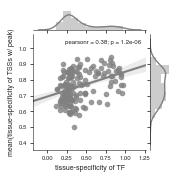

In [56]:
g = sns.jointplot(data=chip_grp, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray")
g.set_axis_labels("tissue-specificity of TF", "mean(tissue-specificity of TSSs w/ peak)")
g.savefig("chip_corr.pdf", dpi="figure", bbox_inches="tight")

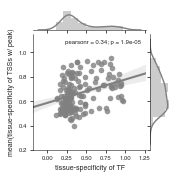

In [57]:
g = sns.jointplot(data=chip_114_grp, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray")
g.set_axis_labels("tissue-specificity of TF", "mean(tissue-specificity of TSSs w/ peak)")
g.savefig("chip_corr_114.pdf", dpi="figure", bbox_inches="tight")

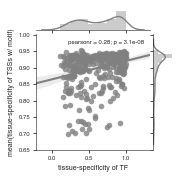

In [58]:
g = sns.jointplot(data=fimo_grp, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray")
g.set_axis_labels("tissue-specificity of TF", "mean(tissue-specificity of TSSs w/ motif)")
g.savefig("motif_corr.pdf", dpi="figure", bbox_inches="tight")

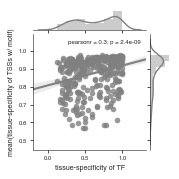

In [59]:
g = sns.jointplot(data=fimo_114_grp, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray")
g.set_axis_labels("tissue-specificity of TF", "mean(tissue-specificity of TSSs w/ motif)")
g.savefig("motif_corr_114.pdf", dpi="figure", bbox_inches="tight")

## 8. do the reverse: find avg. tissue-specifity of TFs within a given gene

In [60]:
chip_grp_rev = chip_ts.groupby(["tss_id", "tissue_spec_x"])["tissue_spec_tau"].agg(["mean", "count"]).reset_index()
chip_grp_rev.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
chip_grp_rev.head()

,tss_id,tss_ts,tf_ts,tf_count
0,chr10:100019738-100019959,0.989906,0.458878,21
1,chr10:100020230-100020246,0.955141,0.458878,21
2,"chr10:100027943..100027958,-",0.782627,0.438689,62
3,chr10:100074404-100074582,0.986803,0.426730,44
4,chr10:100076038-100076149,0.989266,0.430701,43


In [61]:
len(chip_grp_rev)

71695

In [62]:
fimo_grp_rev = fimo_ts.groupby(["tss_id", "tissue_spec_x"])["tissue_spec_tau"].agg(["mean", "count"]).reset_index()
fimo_grp_rev.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
fimo_grp_rev.head()

,tss_id,tss_ts,tf_ts,tf_count
0,chr10:100019738-100019959,0.989906,0.483150,69
1,chr10:100020230-100020246,0.955141,0.481058,68
2,"chr10:100027943..100027958,-",0.782627,0.462732,78
3,chr10:100074404-100074582,0.986803,0.583631,41
4,chr10:100076038-100076149,0.989266,0.619845,45


In [63]:
len(fimo_grp_rev)

82324

In [64]:
chip_114_grp_rev = chip_114_ts.groupby(["tss_id", "tissue_spec_x"])["tissue_spec_tau"].agg(["mean", "count"]).reset_index()
chip_114_grp_rev.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
chip_114_grp_rev.head()

,tss_id,tss_ts,tf_ts,tf_count
0,"chr10:100027943..100027958,-",0.782627,0.159862,3
1,chr10:100074404-100074582,0.986803,0.334956,22
2,chr10:100076500-100076699,0.968955,0.366866,5
3,chr10:100082942-100083374,0.988205,0.372805,36
4,chr10:100120877-100121283,0.940077,0.159862,2


In [65]:
len(chip_114_grp_rev)

29436

In [66]:
fimo_114_grp_rev = fimo_114_ts.groupby(["tss_id", "tissue_spec_x"])["tissue_spec_tau"].agg(["mean", "count"]).reset_index()
fimo_114_grp_rev.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
fimo_114_grp_rev.head()

,tss_id,tss_ts,tf_ts,tf_count
0,"chr10:100027943..100027958,-",0.782627,0.612376,14
1,chr10:100074404-100074582,0.986803,0.549205,20
2,chr10:100076038-100076149,0.989266,0.472680,20
3,chr10:100076500-100076699,0.968955,0.580920,17
4,chr10:100082942-100083374,0.988205,0.617965,33


In [67]:
len(fimo_114_grp_rev)

47290

## 9. plot the reverse

In [68]:
chip_grp_rev["log_tss_ts"] = np.log(chip_grp_rev["tss_ts"]+1)
chip_grp_rev["log_tf_ts"] = np.log(chip_grp_rev["tf_ts"]+1)

fimo_grp_rev["log_tss_ts"] = np.log(fimo_grp_rev["tss_ts"]+1)
fimo_grp_rev["log_tf_ts"] = np.log(fimo_grp_rev["tf_ts"]+1)

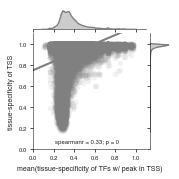

In [69]:
g = sns.jointplot(data=chip_grp_rev, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 1.1), ylim=(0,1.1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("chip_corr_rev.pdf", dpi="figure", bbox_inches="tight")

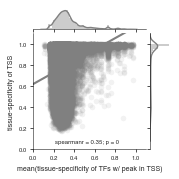

In [70]:
g = sns.jointplot(data=chip_114_grp_rev, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 1.1), ylim=(0,1.1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("chip_corr_rev_114.pdf", dpi="figure", bbox_inches="tight")

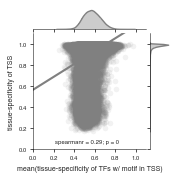

In [71]:
g = sns.jointplot(data=fimo_grp_rev, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", stat_func=spearmanr,
                  xlim=(0, 1.1), ylim=(0,1.1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ motif in TSS)", "tissue-specificity of TSS")
g.savefig("fimo_corr_rev.pdf", dpi="figure", bbox_inches="tight")

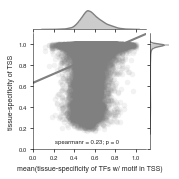

In [72]:
g = sns.jointplot(data=fimo_114_grp_rev, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", stat_func=spearmanr,
                  xlim=(0, 1.1), ylim=(0,1.1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ motif in TSS)", "tissue-specificity of TSS")
g.savefig("fimo_corr_rev_114.pdf", dpi="figure", bbox_inches="tight")